In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances


In [23]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [26]:
# importing modules for the project

import numpy as np
import sklearn
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
# from nltk.corpus import stopwords


%matplotlib inline

np.random.seed(1)

# import nltk
# nltk.download('stopwords')


In [27]:
# movies = pd.read_csv("/content/gdrive/My Drive/movies_pop_updated.csv")
movies = pd.read_csv("cleaned_movies.csv")

In [28]:
movies.head()

,Unnamed: 0,title,id,description,genres,year,director,cast,popularity,average_vote
0,0,Toy Story,862,"Led by Woody, Andy's toys live happily in his ...","animation, comedy, family",1995,John Lasseter,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",21.0,7.7
1,1,Jumanji,8844,When siblings Judy and Peter discover an encha...,"adventure, fantasy, family",1995,Joe Johnston,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",17.0,6.9
2,2,Grumpier Old Men,15602,A family wedding reignites the ancient feud be...,"romance, comedy",1995,Howard Deutch,"Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",11.0,6.5
3,4,Father of the Bride Part II,11862,Just when George Banks has recovered from his ...,comedy,1995,Charles Shyer,"Steve Martin, Diane Keaton, Martin Short, Kimb...",8.0,5.7
4,5,Heat,949,"Obsessive master thief, Neil McCauley leads a ...","action, crime, drama, thriller",1995,Michael Mann,"Al Pacino, Robert De Niro, Val Kilmer, Jon Voi...",17.0,7.7


In [29]:
movies['index'] = range(len(movies))
movies = movies.reset_index()

In [30]:
movie_features = ["director", "cast", "title"]

for feature in movie_features:
    movies[feature] = movies[feature].fillna('')


# Base Score (Director, 4 Cast, Title) 
- cosine similarity with CountVectorizer for the features above
- removed genre since it is heavily weighted in a later section

In [31]:
def combined_features(row):
    return (row['director']+" "+''.join(row['cast'].split(', ')[:4]) + " " + row['title'])
movies["combined_features"] = movies.apply(combined_features, axis =1)

In [32]:
# movies.head()

In [33]:
def base_scores(movies):
  movie_cv = CountVectorizer(stop_words='english')
  CC_count_matrix = movie_cv.fit_transform(movies["combined_features"])
  #print("Count Matrix:", CC_count_matrix.toarray())
  cosine_sim = cosine_similarity(CC_count_matrix)
  #print(cosine_sim)
  return cosine_sim

cosine_sim = base_scores(movies)

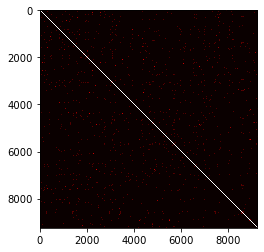

In [34]:
plt.imshow(cosine_sim, cmap='hot', interpolation='nearest')
plt.show()

In [35]:
def fetch_title(movies, title):
    return movies[movies.title == title]["index"].values[0]

def fetch_index(movies, index):
    return movies[movies.index == index]["title"].values[0]

In [36]:
# calculate similarity matrix for base scores
def dcgt_cosine_sim(movies, title, count):
  cosine_sim = base_scores(movies)
  movie_index = fetch_title(movies, title)
  movie_proximity = list(enumerate(cosine_sim[movie_index]))
  movie_proximity_sorted = sorted(movie_proximity, key=lambda x:x[1], reverse=True)
  i = 1;
  print("Recommendations similar to", title, ":")
  while i <= count:
    title = fetch_index(movies, movie_proximity_sorted[i][0])
    print(f"{i}. {title}")
    i+=1


user_title = "Star Wars: The Force Awakens"
num_recommendations = 10
dcgt_cosine_sim(movies, user_title, num_recommendations)

Recommendations similar to Star Wars: The Force Awakens :
1. Star Wars: The Clone Wars
2. Star Trek
3. Star Wars
4. Star Trek Into Darkness
5. Rogue One: A Star Wars Story
6. Star Wars: Episode I - The Phantom Menace
7. Star Wars: Episode II - Attack of the Clones
8. Star Wars: Episode III - Revenge of the Sith
9. Empire of Dreams: The Story of the Star Wars Trilogy
10. Robot Chicken: Star Wars


In [37]:
# https://www.kaggle.com/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
# movies.head()
# movies.shape




`# Genre, Description, Year Similarities
- Genre Score Calculation (Similarity matrix based on genres)
    - Would have used Jaccard score instead, but sklearn doesn't support it on vectorizers. My custom Jaccard score matrix was too slow to compute.
    - Used CountVectorizer and cosine similarity instead
- Description Score Calculation (Similarity matrix based on genres)
    - TfidfVectorizer and cosine similarity to determine the similarity of the short descriptions.
- Year Difference Calculation Matrix (as a penalty for final weight)
- Normalize vectors from 0...1 for popularity and rating to use for final weight

See the combine function to see the weights I used if needed. They are pretty arbitrary, most of the weight is on genre though, then the rest is made up with the other factors.

In [38]:
# return a vector of cosine similarity scores for genres of the title
def genre_scores(movies):
  vectorizer = CountVectorizer()
  matrix = cosine_similarity(vectorizer.fit_transform(movies['genres']))
  return matrix

# return a matrix of tfidf cosine similarity scores for descriptions
def description_scores(movies): 
  vectorizer_request = TfidfVectorizer(stop_words='english')
  tfidf_matrix = vectorizer_request.fit_transform(movies["description"])
  description_similarity = cosine_similarity(tfidf_matrix)
  return description_similarity

# return a matrix of the difference between years for movie release / 100
def year_scores(movies):
  y1 = movies['year'].values
  y2 = movies['year'].values
  matrix = np.abs((y1[None, :] - y2[:, None]) / 100)
  return matrix

def norm(data, max, min):
  result = ((data - min) / (max - min))
  for x in range(len(result)):
    if result[x] > 1:
      result[x] = 1
    if result[x] < 0.05:
      result[x] = 0.05

  return result

yscores = year_scores(movies)
bscores = base_scores(movies)
gscores = genre_scores(movies)
dscores = genre_scores(movies)
pvec = norm(movies['popularity'], 25, 0)
rvec = norm(movies['average_vote'], 10, 0)

print(yscores)
print(pvec)
print(rvec)

[[0.   0.   0.   ... 0.22 0.21 0.04]
 [0.   0.   0.   ... 0.22 0.21 0.04]
 [0.   0.   0.   ... 0.22 0.21 0.04]
 ...
 [0.22 0.22 0.22 ... 0.   0.01 0.26]
 [0.21 0.21 0.21 ... 0.01 0.   0.25]
 [0.04 0.04 0.04 ... 0.26 0.25 0.  ]]
0       0.84
1       0.68
2       0.44
3       0.32
4       0.68
        ... 
9237    0.32
9238    0.36
9239    0.20
9240    0.32
9241    0.20
Name: popularity, Length: 9242, dtype: float64
0       0.77
1       0.69
2       0.65
3       0.57
4       0.77
        ... 
9237    1.00
9238    0.60
9239    0.62
9240    0.56
9241    0.57
Name: average_vote, Length: 9242, dtype: float64


In [39]:
def combine(base_scores, genre_scores, description_scores, year_scores, popularity_vector, rating_vector):
  combined_matrix = np.subtract(np.add(np.add(np.multiply(base_scores, 2), np.multiply(genre_scores, 2)), description_scores), year_scores)
  # weigh based on popularity & rating
  opinion_vector = np.add(popularity_vector, rating_vector)
  return np.add(combined_matrix, np.multiply(opinion_vector[:, np.newaxis], 1))

scores = combine(bscores, gscores, dscores, yscores, pvec, rvec)

/var/folders/sf/mblmxltx6bxc945qnhg523vm0000gn/T/ipykernel_40005/2228919337.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.add(combined_matrix, np.multiply(opinion_vector[:, np.newaxis], 1))


# Recommender Function

In [51]:
def recommend(movies, scores, titles, count):
  array_prox = np.zeros([len(movies), 2])
  array_prox[:,0] = np.array(movies["index"], dtype=int)
  for title in titles:
    movie_index = fetch_title(movies, title)
    movie_proximity = np.array(scores[movie_index])
    array_prox[:,1] = array_prox[:,1] + movie_proximity

  movie_proximity_sorted = array_prox[array_prox[:, 1].argsort()][::-1]

  i = 0
  n = 1
  print("Recommendations:")
  while n <= count:
    title = fetch_index(movies, int(movie_proximity_sorted[i, 0]))
    if title not in titles:
      print(f"{n}. {title}")
      n+=1
    i+=1


num_recommendations = 10
titles = ["The Maze Runner", "Star Wars"]
recommend(movies, scores, titles, num_recommendations)

Recommendations:
1. Star Wars: Episode I - The Phantom Menace
2. Star Wars: Episode II - Attack of the Clones
3. Star Wars: Episode III - Revenge of the Sith
4. Return of the Jedi
5. The Empire Strikes Back
6. Rogue One: A Star Wars Story
7. Mad Max
8. Star Trek: First Contact
9. Star Trek: Insurrection
10. Star Trek: Generations


# Preliminary Exploratory Data Analysis


total of 20 unique genres from 23579 occurances.


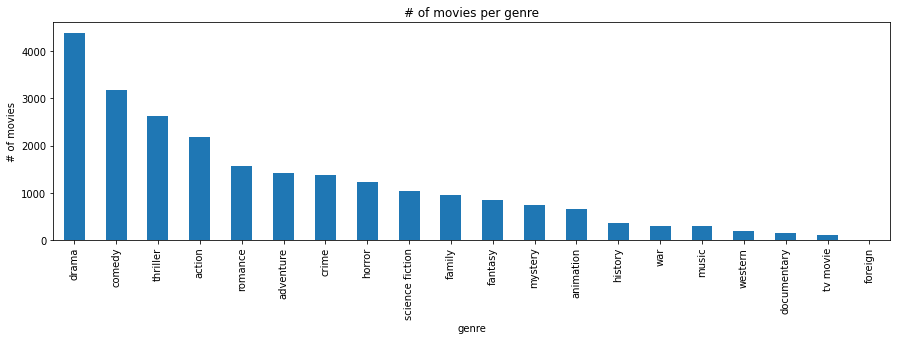

In [21]:
all_genres = [s.split(", ") for s in movies[movies.genres.notnull()].genres]
genres = [item for l in all_genres for item in l ]
unique_genres = set(genres)
print (f"total of {len(unique_genres)} unique genres from {len(genres)} occurances.")
pd.Series(genres).value_counts().plot(kind='bar', figsize=(15, 4))
plt.title("# of movies per genre")
plt.ylabel("# of movies")
plt.xlabel("genre")
plt.show()

In [22]:
movies['year'] = pd.DatetimeIndex(movies['date']).year
movies['year'] = movies['year'].fillna(method="ffill")
movies['year'] = movies['year'].astype(int)
movies.head()

KeyError: ignored

Total of 135 uinque years from 1874 to 2020


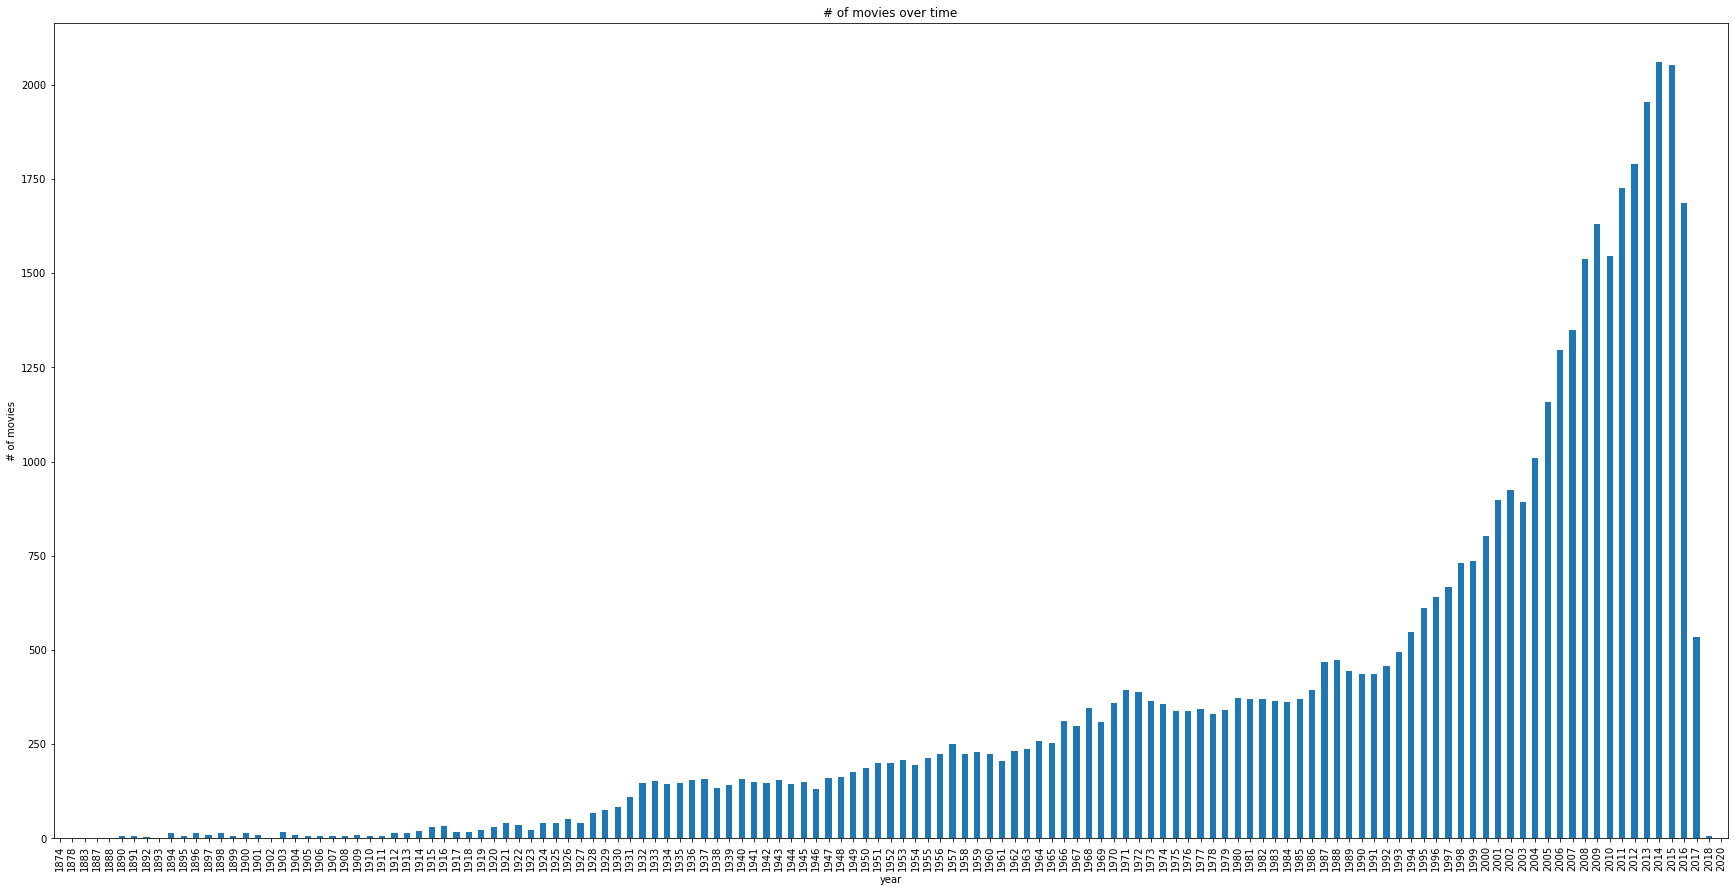

In [ ]:
movies['year'] = movies['year'].replace(0, np.NaN)
years = movies[movies.year.notnull()].year # get rows where year is not None
print (f"Total of {len(set(years))} uinque years from {min(years)} to {max(years)}")
pd.Series(years).value_counts().sort_index().plot(kind='bar', figsize=(30, 15))
plt.title("# of movies over time")
plt.ylabel("# of movies")
plt.xlabel("year")
plt.show()

count    43503.000000
mean         6.014325
std          1.256845
min          0.500000
25%          5.300000
50%          6.100000
75%          6.800000
max         10.000000
Name: average_vote, dtype: float64


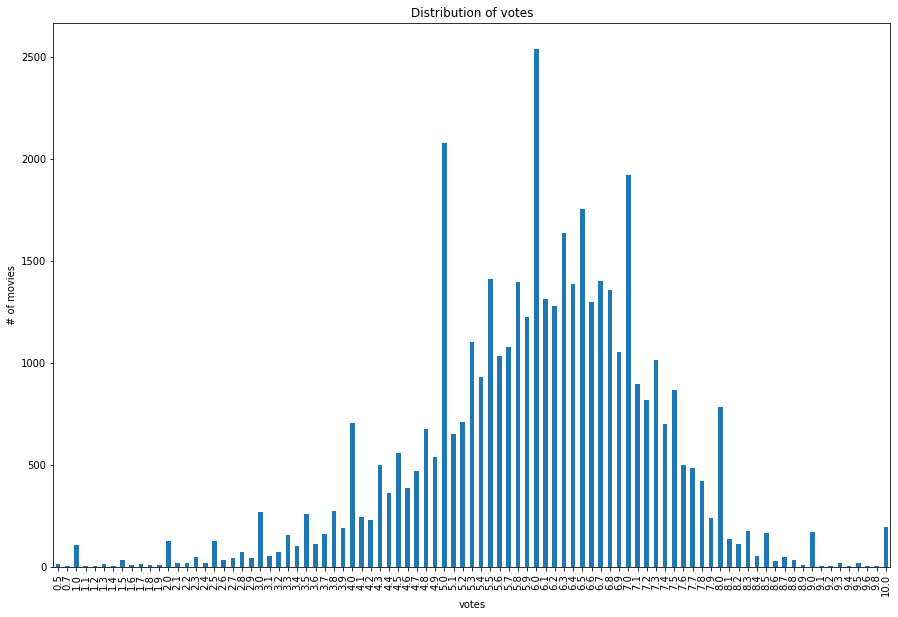

In [ ]:
movies['average_vote'] = movies['average_vote'].replace(0, np.NaN)
print (movies['average_vote'].describe())
pd.Series(movies['average_vote']).value_counts().sort_index().plot(kind='bar', figsize=(15, 10))
plt.title("Distribution of votes")
plt.ylabel("# of movies")
plt.xlabel("votes")
plt.show()

Backup Code Unused

In [ ]:
# # map genres to movie indices containing them
# movie_genres = set()
# genre_idx_map = {}
# for index, genres in enumerate(movies['genres']):
#   genres_list = genres.split(', ')
#   for genre in genres_list:
#     movie_genres.add(genre)
#     if genre in genre_idx_map:
#       genre_idx_map[genre].append(index)
#     else:
#       genre_idx_map[genre] = [index]
  
# print(movie_genres)
# print(genre_idx_map)

  # movie_index = fetch_title(title)
  # title_genres = movies["genres"][movie_index].split(', ')
  # jaccard_vec = []
  # for genres in movies["genres"]:
  #   intersection_c = 0
  #   other_genres = genres.split(', ')
  #   for genre in title_genres:
  #     if genre in other_genres:
  #       intersection_c += 1
  #   union_c = len(title_genres) + len(other_genres) - intersection_c

  #   jaccard_score = intersection_c / union_c
  #   jaccard_vec.append(jaccard_score)

  # movie_index = fetch_title(title)
  # title_genres = movies["genres"][movie_index].split(', ')
  # movie_proximity_sorted = sorted(movie_proximity, key=lambda x:x[1], reverse=True)